In [92]:
import os
import yaml
from torch.utils.data import DataLoader
import argparse

from GeospatialFM.data import get_datasets
from GeospatialFM.models import *
# from utils import load_config
from torchgeo.samplers import RandomGeoSampler
from matplotlib import pyplot as plt

from transformers import TrainingArguments, Trainer
from transformers import AdamW, get_linear_schedule_with_warmup
from GeospatialFM.utils import setup, get_eval_fn, get_data
from GeospatialFM.data import *
from GeospatialFM.models import *
from GeospatialFM.loss import *

from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import numpy as np
from torch.utils.data import ConcatDataset
import segmentation_models_pytorch as smp
from collections import OrderedDict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
def unwrap_model(state_dict):
    new_state_dict = OrderedDict()
    for key, value in state_dict.items():
        new_key = key.replace('module.', '')
        new_state_dict[new_key] = value
    
    return new_state_dict

def norm_image(img):
    img = img - img.min()
    img = img / img.max()
    return img

In [111]:
exp_name = 'mae_cm_reconall_scratch_allTrain'
device = torch.device('cuda:7')

In [112]:
args = {'exp_name': exp_name,
        'config_file': 'GeospatialFM/configs/mae_cm.yaml',
        'opts': None, 
        'save_config': False}
args = argparse.Namespace(**args)
args.debug = True
cfg, _ = setup(args)
args

Namespace(exp_name='mae_cm_reconall_scratch_allTrain', config_file='GeospatialFM/configs/mae_cm.yaml', opts=None, save_config=False, debug=True)

In [85]:
data = get_data(cfg)
sample = iter(data['test'].dataloader).__next__()

In [113]:
save_path = os.path.join(cfg.TRAINER['output_dir'], 'final_model.pth')

model = construct_mae(cfg.MODEL)
state_dict = unwrap_model(torch.load(save_path))
model.load_state_dict(state_dict)
model = model.to(device)

In [114]:
# model.eval()
# with torch.no_grad():
#     out = model(sample['image'].to(device), sample['radar'].to(device))

In [115]:
with torch.no_grad():
    out = model.forward_recon(sample['image'].to(device), sample['radar'].to(device))

In [116]:
sample_idx = 100
rgb_channel = [3, 2, 1]

optical_recon = out['optical_recon'].cpu().numpy()
radar_recon = out['radar_recon'].cpu().numpy()
optical_input = sample['image'].cpu().numpy()
radar_input = sample['radar'].cpu().numpy()
optical_mask = out['optical_mask'].cpu().numpy()
radar_mask = out['radar_mask'].cpu().numpy()

vis_optical_mask = optical_mask[sample_idx].reshape(14, 14)
vis_radar_mask = radar_mask[sample_idx].reshape(14, 14)
optical_recon_all = optical_recon[sample_idx].transpose(1, 2, 0)
radar_recon_all = radar_recon[sample_idx].transpose(1, 2, 0)
optical_input = optical_input[sample_idx].transpose(1, 2, 0)
radar_input = radar_input[sample_idx].transpose(1, 2, 0)

if optical_recon_all.shape[2] >= 13:
    vis_optical_recon_o = optical_recon_all[:, :, rgb_channel]
else:
    vis_optical_recon_o = None

if optical_recon_all.shape[2] > 13:
    vis_optical_recon_r = optical_recon_all[:, :, 13]
elif optical_recon_all.shape[2] == 13:
    vis_optical_recon_r = None
else:
    vis_optical_recon_r = optical_recon_all[:, :, 0]

if radar_recon_all.shape[2] >= 13:
    vis_radar_recon_o = radar_recon_all[:, :, rgb_channel]
else:
    vis_radar_recon_o = None

if radar_recon_all.shape[2] > 13:
    vis_radar_recon_r = radar_recon_all[:, :, 13]
elif radar_recon_all.shape[2] == 13:
    vis_radar_recon_r = None
else:
    vis_radar_recon_r = radar_recon_all[:, :, 0]

vis_optical_input = optical_input[:, :, rgb_channel]
vis_radar_input = radar_input[:, :, 0]

# normalize all images
vis_optical_recon_o = norm_image(vis_optical_recon_o) if vis_optical_recon_o is not None else None
vis_optical_input = norm_image(vis_optical_input)
vis_radar_recon_o = norm_image(vis_radar_recon_o) if vis_radar_recon_o is not None else None


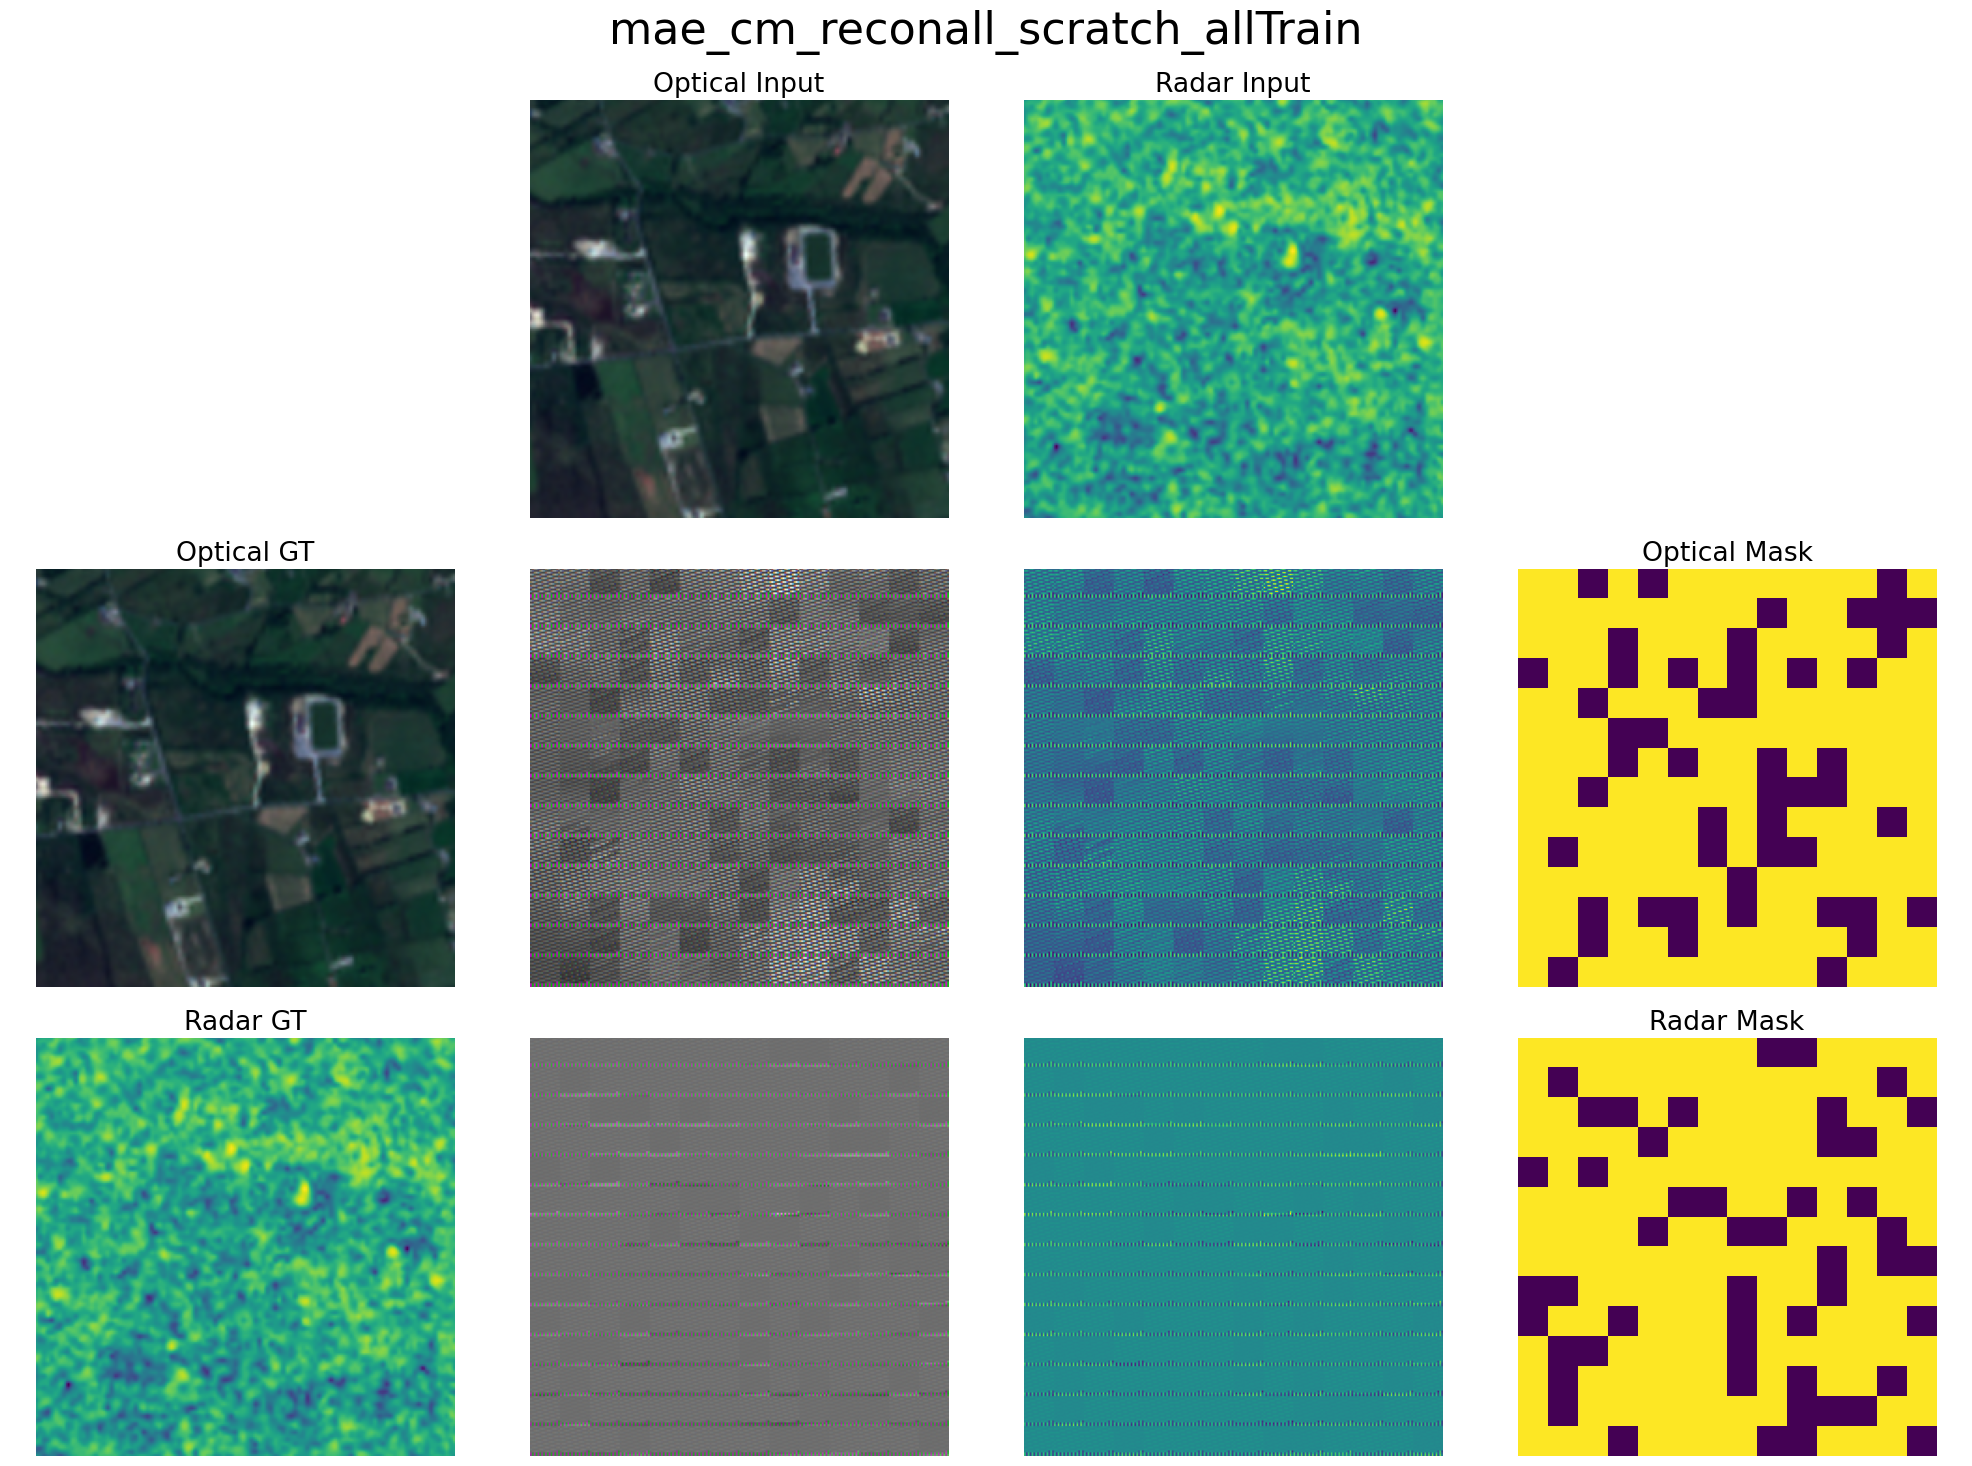

In [117]:
# plot a graph with 2x3 subplots
fig, ax = plt.subplots(3, 4, figsize=(20, 15))
# set font size
plt.rcParams.update({'font.size': 16})

ax[0, 1].imshow(vis_optical_input)
ax[0, 1].set_title('Optical Input')
ax[0, 2].imshow(vis_radar_input)
ax[0, 2].set_title('Radar Input')

ax[1, 0].imshow(vis_optical_input)
ax[1, 0].set_title('Optical GT')
ax[2, 0].imshow(vis_radar_input)
ax[2, 0].set_title('Radar GT')

ax[1, 3].imshow(vis_optical_mask)
# put the title to the right
ax[1, 3].set_title('Optical Mask')
ax[2, 3].imshow(vis_radar_mask)
ax[2, 3].set_title('Radar Mask')

if vis_optical_recon_o is not None:
    ax[1, 1].imshow(vis_optical_recon_o)
if vis_optical_recon_r is not None:
    ax[1, 2].imshow(vis_optical_recon_r)

if vis_radar_recon_o is not None:
    ax[2, 1].imshow(vis_radar_recon_o)
if vis_radar_recon_r is not None:
    ax[2, 2].imshow(vis_radar_recon_r)

# close all the ticks
for axi in ax.ravel():
    axi.axis('off')

fig.suptitle(exp_name, fontsize=32)

plt.tight_layout()